In [486]:
import pandas as pd
import numpy as np

from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
import warnings
warnings.filterwarnings("ignore")
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesse
 
import shap
from dataset import engine, RFM, Churn, Engagement, RFM_engage, RFM_churn
from models import CLFSwitcher, Transform, Pipe, parameters
from sklearn.model_selection import GridSearchCV

In [487]:
rfm = RFM(engine)
engage = Engagement(engine)
churn = Churn(engine)
# churn = churn.get_dataset()[['customer_id', 'churn']]

In [ ]:
rfm.df.head()

In [488]:
# rfm_engage = RFM_engage(rfm, engage)
# rfm_engage.get_X().head()

In [511]:
cus_lst =['Loyal Customers', 'At Risk', 'New Customers', 'Hibernating']

In [540]:
segment = cus_lst[3]

In [541]:
rfm_churn = RFM_churn(rfm, churn, segment=segment)
# rfm_engage = RFM_engage(rfm, engage, segment=segment)

In [542]:
data = rfm_churn

In [543]:
data.df.head()

,customer_id,age,gender,yearly_income,total_debt,deposits,cards,account,loan,churn,segment
0,0001,53,Female,77254.0,191349.0,0,0,1,0,no,Hibernating
1,0002,81,Female,33483.0,196.0,1,1,1,0,yes,At Risk
2,0003,63,Female,249925.0,202328.0,0,0,1,0,yes,Hibernating
3,0004,43,Male,109687.0,183855.0,0,0,1,0,no,Loyal Customers
4,0005,42,Male,41997.0,0.0,0,0,1,0,no,Hibernating


In [544]:
X = data.get_X()
y = data.get_y()
ct = Transform(data)
X, y = ct.get_Xy()
# ct.inverse_transform(pd.concat([X, y], axis=1))
# y

In [545]:
pipeline = Pipe(ct).get_pipeline()
def train(X, y, pipeline, parameters):
        grid_search = GridSearchCV(pipeline, parameters, cv=2, n_jobs=12, return_train_score=True, verbose=2)
        grid_search.fit(X, y)
        return grid_search, grid_search.best_estimator_[-1]
_, best_estimator = train(X, y, pipeline, parameters)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


In [546]:
best_estimator.explain(data, ct)

.values =
array([[-4.34270667e-05,  0.00000000e+00, -9.69117286e-05,
        -1.13904146e-03,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-2.45349502e-04,  0.00000000e+00, -3.84984180e-04,
        -1.71930841e-05,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 5.19405376e-05,  0.00000000e+00, -3.44523509e-04,
        -5.98078258e-04,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-9.10535803e-05,  0.00000000e+00,  4.99970891e-04,
         3.21312274e-04,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 5.06585470e-05,  0.00000000e+00,  3.00231129e-04,
        -1.63026994e-03,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 4.35537915e-05,  0.00000000e+00, -5.90194357e-04,
        -4.63297700e-05,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-3.92051201e-04,

In [547]:
# rfm_engage.df.columns
rfm_churn.df.columns

Index(['customer_id', 'age', 'gender', 'yearly_income', 'total_debt',
       'deposits', 'cards', 'account', 'loan', 'churn', 'segment'],
      dtype='object')

In [548]:
# rfm_engage.df.head()
rfm_churn.df.head()

,customer_id,age,gender,yearly_income,total_debt,deposits,cards,account,loan,churn,segment
0,0001,53,Female,77254.0,191349.0,0,0,1,0,no,Hibernating
1,0002,81,Female,33483.0,196.0,1,1,1,0,yes,At Risk
2,0003,63,Female,249925.0,202328.0,0,0,1,0,yes,Hibernating
3,0004,43,Male,109687.0,183855.0,0,0,1,0,no,Loyal Customers
4,0005,42,Male,41997.0,0.0,0,0,1,0,no,Hibernating


In [549]:
# shap_df = best_estimator.get_shap(X_col='target_segment', y_col='action_type', y_val='converted')

In [550]:
shap_df = best_estimator.get_shap(X_col='age', y_col='churn', y_val='yes')

In [551]:
# plt.scatter(shap_df.iloc[:, -1], shap_df.iloc[:,0])
# plt.xlabel(shap_df.columns[1])
# plt.ylabel(shap_df.columns[0])
# plt.title(f'{shap_df.columns[1]} vs. {shap_df.columns[0]}')

In [552]:
shap_df_1 = best_estimator.get_shap(X_col='age', y_col='churn', y_val='yes')
shap_df_2 = best_estimator.get_shap(X_col='gender', y_col='churn', y_val='yes')
shap_df_3 = best_estimator.get_shap(X_col='yearly_income', y_col='churn', y_val='yes')
shap_df_4 = best_estimator.get_shap(X_col='total_debt', y_col='churn', y_val='yes')

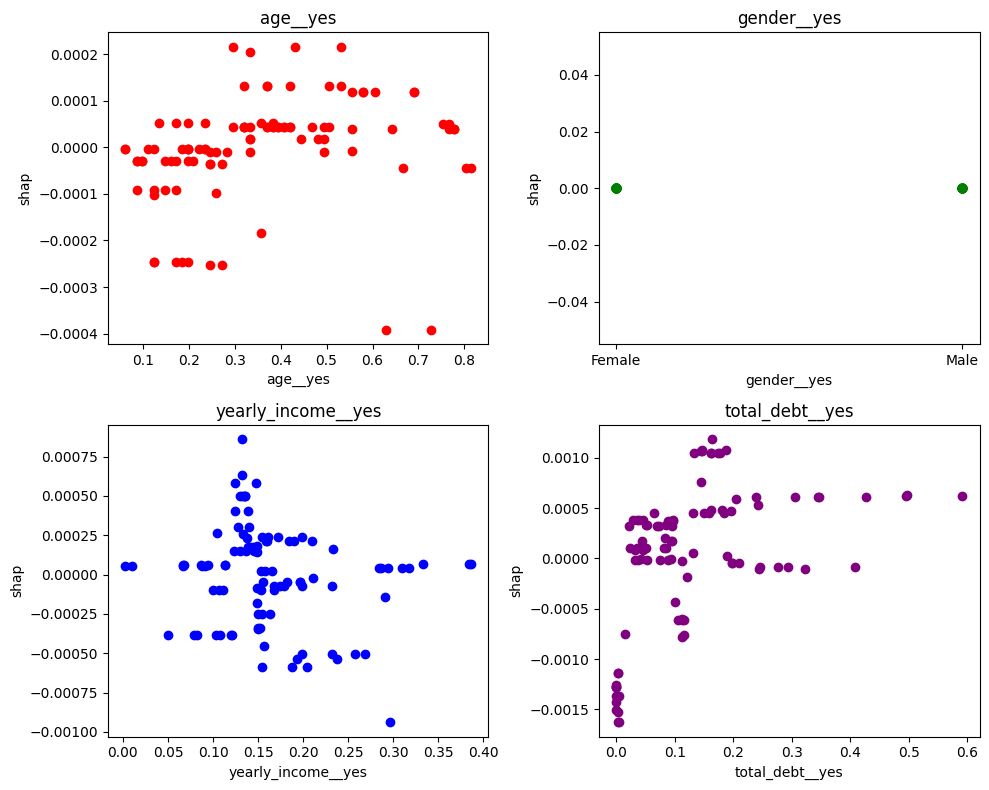

In [553]:
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Top-left plot
axs[0, 0].scatter(shap_df_1.iloc[:, -1], shap_df_1.iloc[:, 0], color='red')
axs[0, 0].set_xlabel(shap_df_1.columns[-1])
axs[0, 0].set_ylabel(shap_df_1.columns[0])
axs[0, 0].set_title(f'{shap_df_1.columns[-1]}')

# Top-right plot
axs[0, 1].scatter(shap_df_2.iloc[:, -1], shap_df_2.iloc[:, 0], color='green')
axs[0, 1].set_xlabel(shap_df_2.columns[-1])
axs[0, 1].set_ylabel(shap_df_2.columns[0])
axs[0, 1].set_title(f'{shap_df_2.columns[-1]}')

# Bottom-left plot
axs[1, 0].scatter(shap_df_3.iloc[:, -1], shap_df_3.iloc[:, 0], color='blue')
axs[1, 0].set_xlabel(shap_df_3.columns[-1])
axs[1, 0].set_ylabel(shap_df_3.columns[0])
axs[1, 0].set_title(f'{shap_df_3.columns[-1]}')

# Bottom-right plot
axs[1, 1].scatter(shap_df_4.iloc[:, -1], shap_df_4.iloc[:, 0], color='purple')
axs[1, 1].set_xlabel(shap_df_4.columns[-1])
axs[1, 1].set_ylabel(shap_df_4.columns[0])
axs[1, 1].set_title(f'{shap_df_4.columns[-1]}')

# Adjust layout
plt.tight_layout()
plt.show()
